<a href="https://colab.research.google.com/github/pipeton8/pattern-recognition/blob/main/assignments/2%20-%20Gender%20recognition/assignment2_fdc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Pattern Recognition

(c) Felipe del Canto, May 2021

---

# Gender recognition

# 0. Preamble

## Load libraries

In [ ]:
from IPython.display import clear_output

!pip install scipy==1.2
!pip3 install pybalu==0.2.5
clear_output()
print('PyBalu library installed.')

PyBalu library installed.


In [ ]:
!pip uninstall opencv-python -y
!pip install opencv-python
clear_output()

import cv2 as cv

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from   seaborn import heatmap

from   tqdm.auto import tqdm

from   sklearn.metrics import confusion_matrix, accuracy_score
from   sklearn.neighbors import KNeighborsClassifier
from   sklearn.decomposition import PCA

from   pybalu.feature_extraction import lbp_features, hog_features
from   pybalu.feature_selection import clean

## Load database

In [ ]:
!wget 'https://github.com/pipeton8/pattern-recognition/raw/main/assignments/databases/argender.zip' -O 'argender.zip'
!unzip -o 'argender.zip'
!rm 'argender.zip'
clear_output()
print("Database Loaded")

Database Loaded


## Image manipulation functions

In [ ]:
def num2fixstr(x,d):
  # example num2fixstr(2,5) returns '00002'
  # example num2fixstr(19,3) returns '019'
  st = '%0*d' % (d,x)
  return st

def ImageLoad(prefix, num_char, num_img, echo='off'):
  st   = prefix + num2fixstr(num_char,3) + '_' + num2fixstr(num_img,4) + '.png'

  if echo == 'on':
    print('loading image '+st+'...')

  return plt.imread(st)


def ImageSplit(img, vdiv=1, hdiv=1):
  subImgHeight = img.shape[0] // vdiv
  subImgWidth  = img.shape[1] // hdiv
  
  imgs = [img[subImgHeight*i : subImgHeight*(i+1), 
              subImgWidth*j:subImgWidth*(j+1)] 
                for i in range(vdiv) for j in range(hdiv)]

  return imgs

## Normalization

In [ ]:
def minmax(X):
  min = X.min(axis=0) # vector of column-wise minima
  max = X.max(axis=0) # vector of column-wise maxima

  range         = max - min   # vector of column-wise ranges
  scale_coef    = 1/range     # scale coefficient
  position_coef = -min/range  # position coefficient

  # Return normalized features and coefficients to normalize test set
  return X*scale_coef + position_coef, scale_coef, position_coef

## SIFT

In [ ]:
# SIFT extraction
def SIFT_features(img, normalize=True):
  SIFT_extractor = cv.features2d.SIFT_create()
  _, desc = SIFT_extractor.detectAndCompute(img, None)

  if normalize:
    norm = np.reshape(np.linalg.norm(desc,axis=1),desc.shape[0])
    desc = desc/norm

  return desc

def SIFT_reduce(Xsift, n_components, finalKeypoints):

  pca = PCA(n_components=n_components)
  Xsift_pca = pca.fit_transform(Xsift)

  for i in range(n_components):
    # sort starting from the last column
    currentColumn = (n_components-1) - i

    newOrder = np.argsort(Xsift_pca[:,currentColumn])
    Xsift_pca = Xsift_pca[newOrder,:]

  if finalKeyPoints > Xsfit_pca.shape[0]:
    paddingShape = (finalKeyPoints - Xsift_pca.shape[0], Xsift_pca.shape[1])

    return np.concatenate((Xsift_pca,np.zeros(paddingShape)))

  return Xsift_pca[:finalKeyPoints,:]

## Training and classifying functions

In [ ]:
# Create train and test sets
def SplitTrainTest(X,y,n, preprocess= True, random='not', batch_size = -1, seed = 0):

  K      = np.int(np.max(y))+1      # number of classes   
  N      = np.int(X.shape[0]/K)     # images per class
  
  if random == 'all':
    np.random.seed(seed)
    rows_selected = np.sort(np.random.choice([i for i in range(N)], n, replace=False))
  
  elif random == 'batch':
    if batch_size == -1 or N % batch_size != 0 or n % batch_size != 0 or type(batch_size) != int:
      raise ValueError("batch_size does not comply with matrix size")
    
    batch_number = np.int(N/batch_size)
    batchesToChoose = np.int(n/batch_size)

    np.random.seed(seed)
    batches_selected = np.sort(np.random.choice([i for i in range(batch_number)], batchesToChoose, replace=False))
    rows_selected = [batch*batch_size + i for batch in batches_selected for i in range(batch_size)]

  else:
    rows_selected = [i for i in range(n)]

  rowsTrain = np.array([i+j*N for j in range(K) for i in rows_selected])
  rowsTest = np.array([i for i in range(X.shape[0]) if i not in rowsTrain])

  Xtrain = X[rowsTrain,:]
  Xtest  = X[rowsTest,:]

  if preprocess:
    # Select columns that are not constant and for those which are highly correlated, 
    # leave only one occurrence. This selection is done only in the train set.
    clean_selection = clean(Xtrain)

    Xtrain_sel  = Xtrain[:,clean_selection]
    Xtest_sel   = Xtest[:,clean_selection]

    # Normalize train set
    Xtrain_norm, a, b = minmax(Xtrain_sel)

    # Normalize test set based on training coefficients
    Xtest_norm = Xtest_sel * a + b

  return Xtrain_norm,y[rowsTrain],Xtest_norm,y[rowsTest],rowsTest

In [ ]:
# Confusion matrix print function
def printConfusionMatrix(C, mode='heatmap'):
  if mode == 'heatmap':

    heatmap(C, annot=True, cbar=None, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")

    labels = ['Man', 'Woman']
    plt.xticks([0.5,1.5], labels)
    plt.yticks([0.5,1.5], labels, va = 'center')

    plt.show()

  else:  
    print('\nConfusion matrix:')
    print(C)

  return None

# KNN classifier
def ClassifierKNN(Xtrain,ytrain,Xtest,ytest, n_neighbors = 3, echo = 'off'):
  knn = KNeighborsClassifier(n_neighbors=n_neighbors)
  knn.fit(Xtrain, ytrain)

  ypred        = knn.predict(Xtest)
  acc          = accuracy_score(ytest,ypred)
  C            = confusion_matrix(ytest,ypred)
  
  if echo == 'on':
    print('Testing Accuracy = {:.2f}%'.format(acc*100))
    printConfusionMatrix(C)
  
  return acc,C,ypred

# 1. Image analysis

## 1. Splitting images

Splitting images can be important when extracting certain features. In this case, splitting each face in (for example) three parts allows the creation of three major features:
  - Forehead and eyebrows.
  - Eyes and nose.
  - Mouth and chin.

In principle, this partition could allow for a better prediction.

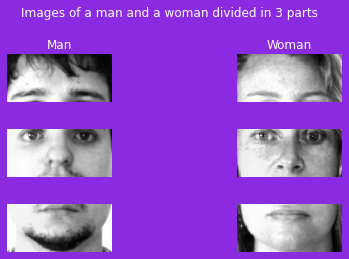

In [ ]:
# Parameters
vdiv = 3  # Number of vertical divisions
hdiv = 1  # Number of horizontal divisions
imageToLoad = 20 # image number to load 

# Create plots and title
fig, axs = plt.subplots(vdiv, 2*hdiv+1, sharex = 'all', sharey = 'all')
fig.patch.set_facecolor('blueviolet')
fig.suptitle("Images of a man and a woman divided in {:d} parts".format(vdiv*hdiv),y=1.01,color='white')

# Place images in plot
for k in range(2):
  # Load image
  img = ImageLoad("argender/face_",k+1,imageToLoad,echo='off')

  # Set woman/man title
  image_title = "Man"*(k == 0) + "Woman"*(k==1)
  axs[0,k*(hdiv+1)+(hdiv-1)//2].set_title("{:s}".format(image_title),color='white')

  # Split image
  imgs = ImageSplit(img,vdiv=vdiv, hdiv=hdiv)
  
  # Place image in corresponding place
  for i in tqdm(range(vdiv)):
    for j in range(hdiv):
      axs[i,k*(hdiv+1) + j].imshow(imgs[i*hdiv+j],cmap='gray')
      axs[i,k*(hdiv+1) + j].set_axis_off()

# Turn off separating axes
for i in tqdm(range(vdiv)):
  axs[i,hdiv].set_visible(False)
  axs[i,hdiv].set_axis_off()

plt.subplots_adjust(hspace=0.1, wspace=0.1)

# 2. Feature extraction

In [ ]:
## General parameters
K    = 2    # number of classes
N    = 700  # number of images per class

## LBP parameters
hdiv = 3    # number of vertical cuts on the image
Mlbp = 59   # size of the LBP vector

## HoG parameters
v_windows = 16 # number of vertical windows
h_windows = 10 # number of horizontal windows
n_bins    = 9 # number of bins

## SIFT parameters
n_components  = 1
finalKeypoints = 100

## Feature matrices
Xlbp_noDiv = np.zeros((K*N,Mlbp))                         # K*N images (rows), and Mlbp      features (columns)
Xlbp       = np.zeros((K*N,Mlbp*hdiv))                    # K*N images (rows), and Mlbp*hdiv features (columns)
Xhog       = np.zeros((K*N,v_windows*h_windows*n_bins))   #
Xsift      = np.zeros((K*N,n_components*finalKeypoints))  #

## Ground truth
y     = np.concatenate((np.zeros(N,'int'),np.ones(N,'int')))

print('Loading images and extracting features...')
for j in range(K):

  print('Extracting features: class '+str(j+1)+'/'+str(K))
  
  for i in tqdm(range(N)):
    # Image read
    img    = 255*ImageLoad('argender/face_',j+1,i+1,echo='off')

    # Classic LBP
    Xlbp_noDiv[j*N+i,:] = lbp_features(img, hdiv=1,    vdiv=1, mapping='nri_uniform')
    Xlbp[j*N+i,:]       = lbp_features(img, hdiv=hdiv, vdiv=1, mapping='nri_uniform')

    # Histogram of gradients (HoG)
    Xhog[j*N+i,:] = hog_features(img, v_windows = v_windows, h_windows=h_windows,n_bins=n_bins)

    # SIFT
    #SIFT_f                        = SIFT_reduce(SIFT_features(img), n_components=n_components, finalKeypoints=finalKeypoints)
    #Xsift[j*N+i,:]                = SIFT_f.flatten()

Loading images and extracting features...
Extracting features: class 1/2



Extracting features: class 2/2


## Features to consider

In [ ]:
X = np.concatenate((Xlbp_noDiv, Xlbp, Xhog), axis=1)

# 4. Experiments

In each subsection, the experiments are sorted in increasing order of accuracy. For every experiment, with the exception of SFS, the classification is repeated 100 times and the accuracy and confusion matrix reported are averages across all replications. 

The experiments are comparable by setting the appropiate seeds for each replication.

For SFS, only 1 experiment was conducted.

All code snippets work independently after setting the parameters below.

## 1. Feature selection

| Strategy   | SFS/SBS<br>Columns |  Accuracy  | Wrongly<br> labeled men | Wrongly<br> labeled women |
|------------|:--------------------------:|:-------------------:|:----------------------------------:| :-----------------: |
| SFS (all features)    | 12             | 77.86% | 2 | 29  |
| SFS (per feature set) | 12 (4 per set) | 83.57% |3 | 20 |
| SBS (all features)    | 12             | 77.86% | 2 | 29  |
| SBS (per feature set) | 12 (4 per set) | 83.57% |3 | 20 |

### SFS over all features (library ```mlxtend```)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


Running SFS over 1676 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 370 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:   33.2s
[Parallel(n_jobs=-1)]: Done 1570 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 1676 out of 1676 | elapsed:  1.1min finished
Features: 1/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 888 tasks      | elapsed:   33.1s
[Parallel(n_jobs=-1)]: Done 1588 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 1675 out of 1675 | elapsed:  1.0min finished
Features: 2/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 388 tasks   



Testing Accuracy = 77.86%


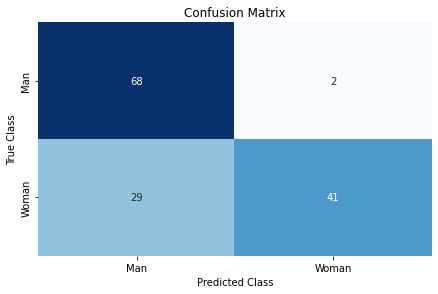

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Parameters
nTrain         = 630 # size of training set

sfs_columns    = 5   # number of features to select in sfs or sbs

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
          k_features=sfs_columns,
          forward=True,
          floating=False,
          verbose=1,scoring='accuracy',cv=0, n_jobs=-1)

# Run experiment
Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=0)

# Fit SFS model
print("Running SFS over {:d} features".format(Xtrain.shape[1]))
sfs = sfs.fit(Xtrain, ytrain)
print("\n")

# Select columns
sel_cols   = list(sfs.k_feature_idx_)
Xtrain_sfs = Xtrain[:,sel_cols]
Xtest_sfs  = Xtest[:,sel_cols]

# Classification
acc,C,ypred = ClassifierKNN(Xtrain_sfs, ytrain, Xtest_sfs, ytest, n_neighbors=3, echo='on')

### SFS per set of features (library ```mlxtend```)

Running SFS over 59 features... Done
Running SFS over 177 features... Done
Running SFS over 1440 features... Done
Testing Accuracy = 83.57%


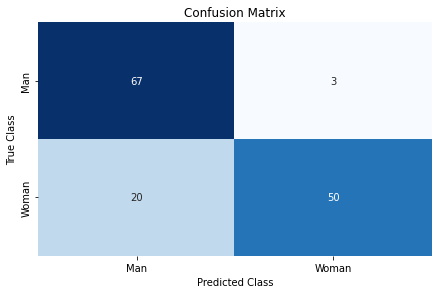

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Parameters
nTrain         = 630 # size of training set

sfs_columns    = 4   # number of columns to select per feature

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
          k_features=sfs_columns,
          forward=True,
          floating=False,
          verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

# Initialize matrix of features
Xtrain_sfs = np.zeros((nTrain*K,1))
Xtest_sfs  = np.zeros((X.shape[0]-Xtrain_sfs.shape[0],1))

for Xf in [Xlbp_noDiv, Xlbp, Xhog]:
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(Xf,y,nTrain,random='batch', batch_size = batch_size, seed=0)

  # Fit SFS model
  print("Running SFS over {:d} features".format(Xtrain.shape[1]),end="")
  sfs = sfs.fit(Xtrain, ytrain)
  print("... Done")

  # Select columns
  sel_cols   = list(sfs.k_feature_idx_)
  Xtrain_sfs = np.concatenate((Xtrain_sfs,Xtrain[:,sel_cols]),axis=1)
  Xtest_sfs  = np.concatenate((Xtest_sfs,Xtest[:,sel_cols]),axis=1)

# Classification
acc,C,ypred = ClassifierKNN(Xtrain_sfs[:,1:], ytrain, Xtest_sfs[:,1:], ytest, n_neighbors=3, echo='on')

### SBS over all features (library ```mlxtend```)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Parameters
nTrain         = 630 # size of training set

sfs_columns    = 5   # number of features to select in sfs or sbs

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
          k_features=sfs_columns,
          forward=False,
          floating=False,
          verbose=1,scoring='accuracy',cv=0, n_jobs=-1)

# Run experiment
Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=0)

# Fit SFS model
print("Running SBS over {:d} features".format(Xtrain.shape[1]))
sfs = sfs.fit(Xtrain, ytrain)
print("\n")

# Select columns
sel_cols   = list(sfs.k_feature_idx_)
Xtrain_sfs = Xtrain[:,sel_cols]
Xtest_sfs  = Xtest[:,sel_cols]

# Classification
acc,C,ypred = ClassifierKNN(Xtrain_sfs, ytrain, Xtest_sfs, ytest, n_neighbors=3, echo='on')

Running SBS over 1676 features


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 54.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 85.4min
[Parallel(n_jobs=-1)]: Done 1676 out of 1676 | elapsed: 114.9min finished
Features: 1675/5[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 30.7min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed: 54.9min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed: 85.8min
[Parallel(n_jobs=-1)]: Done 1675 out of 1675 | elapsed: 115.1min finished
Features: 1674/5[Parallel(n_jobs=-1)]: Using backend LokyBacke

### SBS per set of features (library ```mlxtend```)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Parameters
nTrain         = 630 # size of training set

sfs_columns    = 4   # number of columns to select per feature

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
          k_features=sfs_columns,
          forward=False,
          floating=False,
          verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

# Initialize matrix of features
Xtrain_sfs = np.zeros((nTrain*K,1))
Xtest_sfs  = np.zeros((X.shape[0]-Xtrain_sfs.shape[0],1))

for Xf in [Xlbp_noDiv, Xlbp, Xhog]:
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(Xf,y,nTrain,random='batch', batch_size = batch_size, seed=0)

  # Fit SFS model
  print("Running SBS over {:d} features".format(Xtrain.shape[1]),end="")
  sfs = sfs.fit(Xtrain, ytrain)
  print("... Done")

  # Select columns
  sel_cols   = list(sfs.k_feature_idx_)
  Xtrain_sfs = np.concatenate((Xtrain_sfs,Xtrain[:,sel_cols]),axis=1)
  Xtest_sfs  = np.concatenate((Xtest_sfs,Xtest[:,sel_cols]),axis=1)

# Classification
acc,C,ypred = ClassifierKNN(Xtrain_sfs[:,1:], ytrain, Xtest_sfs[:,1:], ytest, n_neighbors=3, echo='on')

## 2. Feature transformation

| Strategy   | PCA/ICA/PSLR<br>Components |  Average<br>Accuracy  | Wrongly labeled<br>men (average) | Wrongly labeled<br> women (average) |
|------------|:--------------------------:|:-------------------:|:----------------------------------:| :-----------------: |
| ICA  |  12  | 84.34% | 8.3 | 14  |
| PCA  |  12  | 86.50% | 6.8 | 12  |
| PLSR |  12  | 94.55% | 3.7 | 3.9 |

### ICA (library ```sklearn```)

In [ ]:
from sklearn.decomposition import FastICA

# Parameters
nTrain         = 630 # size of training set

n_components   = 12  # ICA, PCA and PSLR components

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
ica = FastICA(n_components=n_components)

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=rep)

  # Fit and transform train and test data
  Xtrain_ica  = ica.fit_transform(Xtrain)
  Xtest_ica   = ica.transform(Xtest)

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_ica,ytrain,Xtest_ica,ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

### PCA (library ```sklearn```)

In [ ]:
from   sklearn.decomposition import PCA

# Parameters
nTrain         = 630 # size of training set

n_components   = 12  # ICA, PCA and PSLR components

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
pca = PCA(n_components=n_components)

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=rep)

  # Fit and transform train and test data
  Xtrain_pca  = pca.fit_transform(Xtrain)
  Xtest_pca   = pca.transform(Xtest)

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_pca,ytrain,Xtest_pca,ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)


### PSLR (library ```sklearn```)

In [ ]:
from sklearn.cross_decomposition import PLSRegression  

# Parameters
nTrain         = 630 # size of training set

n_components   = 12  # ICA, PCA and PSLR components

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
plsr = PLSRegression(n_components=n_components)

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=rep)

  # Fit and transform train and test data
  plsr.fit(Xtrain,ytrain)
  Xtrain_plsr  = plsr.transform(Xtrain)
  Xtest_plsr   = plsr.transform(Xtest)

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_plsr,ytrain,Xtest_plsr,ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

## 3. Mixed strategies (selection and transformation)

| Strategy   | PCA/ICA/PSLR<br>components | SFS<br>columns |  Average<br>Accuracy  | Wrongly labeled<br>men (average) | Wrongly labeled<br> women (average) |
|------------|:--------------------------:|:--------------------:|:-------------------:|:----------------------------------:| :-----------------: |
| ICA + SFS  |  12  | **12**<br><br>10<br><br>6<br><br>4<br><br>1 | **84.34%**<br><br>85.16%<br><br>84.50%<br><br>84.01%<br><br>79.34% | **8.3**<br><br>8.5<br><br>10<br><br>10<br><br>15 | **14**<br><br>12<br><br>12<br><br>12<br><br>14 |
| PCA + SFS  |  12  | **12**<br><br>10<br><br>6<br><br>4<br><br>1 | **86.50%**<br><br>87.34%<br><br>86.41%<br><br>85.02%<br><br>71.34% | **6.8**<br><br>6.5<br><br>8<br><br>10<br><br>20 | **12**<br><br>11<br><br>11<br><br>11<br><br>20 |
| PLSR + SFS |  12  | **12**<br><br>10<br><br>6<br><br>4<br><br>1 | **94.55%**<br><br>95.09%<br><br>95.24%<br><br>94.17%<br><br>86.24% | **3.7**<br><br>3.4<br><br>3.5<br><br>4<br><br>8.8 | **3.9**<br><br>3.5<br><br>3.2<br><br>4.2<br><br>10 |



### ICA and SFS

In [ ]:
from sklearn.decomposition import FastICA

# Parameters
nTrain         = 630 # size of training set

n_components   = 20  # ICA, PCA and PSLR components
sfs_columns    = 12   # number of features to select in sfs or sbs

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
ica = FastICA(n_components=n_components)

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=rep)

  # Fit and transform train and test data
  Xtrain_ica  = ica.fit_transform(Xtrain)
  Xtest_ica   = ica.transform(Xtest)

  # SBS
  seqSel = SFS(KNeighborsClassifier(n_neighbors=5), 
            k_features=sfs_columns,
            forward=True,
            floating=False,
            verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

  seqSel = seqSel.fit(Xtrain_ica, ytrain)

  # Select columns
  sel_cols   = list(seqSel.k_feature_idx_)
  Xtrain_sfs = Xtrain_ica[:,sel_cols]
  Xtest_sfs  = Xtest_ica[:,sel_cols]

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_sfs, ytrain, Xtest_sfs, ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

### PCA and SFS

In [ ]:
from   sklearn.decomposition import PCA

# Parameters
nTrain         = 630 # size of training set

n_components   = 20  # ICA, PCA and PSLR components
sfs_columns    = 12   # number of features to select in sfs or sbs

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
pca = PCA(n_components=n_components)

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=rep)

  # Fit and transform train and test data
  Xtrain_pca  = pca.fit_transform(Xtrain)
  Xtest_pca   = pca.transform(Xtest)

  # SBS
  seqSel = SFS(KNeighborsClassifier(n_neighbors=5), 
            k_features=sfs_columns,
            forward=True,
            floating=False,
            verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

  seqSel = seqSel.fit(Xtrain_pca, ytrain)

  # Select columns
  sel_cols   = list(seqSel.k_feature_idx_)
  Xtrain_sfs = Xtrain_pca[:,sel_cols]
  Xtest_sfs  = Xtest_pca[:,sel_cols]

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_sfs,ytrain,Xtest_sfs,ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

### PSLR and SFS

In [ ]:
from sklearn.cross_decomposition import PLSRegression  

# Parameters
nTrain         = 630 # size of training set

n_components   = 20  # ICA, PCA and PSLR components
sfs_columns    = 12  # number of features to select in sfs or sbs

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Number of components and model creation
plsr = PLSRegression(n_components=n_components)

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):
  Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(X,y,nTrain,random='batch', batch_size = batch_size, seed=rep)

  # Fit and transform train and test data
  plsr.fit(Xtrain,ytrain)
  Xtrain_plsr  = plsr.transform(Xtrain)
  Xtest_plsr   = plsr.transform(Xtest)

  # SFS
  seqSel = SFS(KNeighborsClassifier(n_neighbors=5), 
            k_features=sfs_columns,
            forward=True,
            floating=False,
            verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

  seqSel = seqSel.fit(Xtrain_plsr, ytrain)

  # Select columns
  sel_cols      = list(seqSel.k_feature_idx_)
  Xtrain_seqSel = Xtrain_plsr[:,sel_cols]
  Xtest_seqSel  = Xtest_plsr[:,sel_cols]

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_seqSel,ytrain,Xtest_seqSel,ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

### ICA and SFS per set

In [ ]:
from sklearn.decomposition import FastICA

# Parameters
nTrain         = 630 # size of training set

n_components   = 12  # ICA, PCA and PSLR components per set of features
sfs_columns    = 4  # number of features to select in sfs per set

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):

  # Initialize matrix of features
  Xtrain_sfs = np.zeros((nTrain*K,1))
  Xtest_sfs  = np.zeros((X.shape[0]-Xtrain_sfs.shape[0],1))

  for Xf in [Xlbp_noDiv, Xlbp, Xhog]:
    Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(Xf,y,nTrain,random='batch', batch_size = batch_size, seed=0)

    # Number of components and model creation
    ica = FastICA(n_components=n_components)

    # Fit and transform train and test data
    Xtrain_ica  = ica.fit_transform(Xtrain)
    Xtest_ica   = ica.transform(Xtest)

    # SFS
    sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
              k_features=sfs_columns,
              forward=True,
              floating=False,
              verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

    sfs = sfs.fit(Xtrain_ica, ytrain)

    # Select columns
    sel_cols   = list(sfs.k_feature_idx_)
    Xtrain_sfs = np.concatenate((Xtrain_sfs,Xtrain_ica[:,sel_cols]),axis=1)
    Xtest_sfs  = np.concatenate((Xtest_sfs,Xtest_ica[:,sel_cols]),axis=1)

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_sfs[:,1:], ytrain, Xtest_sfs[:,1:], ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

### PCA and SFS per set

In [ ]:
from   sklearn.decomposition import PCA

# Parameters
nTrain         = 630 # size of training set

n_components   = 12  # ICA, PCA and PSLR components per set of features
sfs_columns    = 4  # number of features to select in sfs per set

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):

  # Initialize matrix of features
  Xtrain_sfs = np.zeros((nTrain*K,1))
  Xtest_sfs  = np.zeros((X.shape[0]-Xtrain_sfs.shape[0],1))

  for Xf in [Xlbp_noDiv, Xlbp, Xhog]:
    Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(Xf,y,nTrain,random='batch', batch_size = batch_size, seed=0)

    # Number of components and model creation
    pca = PCA(n_components=n_components)

    # Fit and transform train and test data
    Xtrain_pca  = pca.fit_transform(Xtrain)
    Xtest_pca   = pca.transform(Xtest)

    # SFS
    sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
              k_features=sfs_columns,
              forward=True,
              floating=False,
              verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

    sfs = sfs.fit(Xtrain_pca, ytrain)

    # Select columns
    sel_cols   = list(sfs.k_feature_idx_)
    Xtrain_sfs = np.concatenate((Xtrain_sfs,Xtrain_pca[:,sel_cols]),axis=1)
    Xtest_sfs  = np.concatenate((Xtest_sfs,Xtest_pca[:,sel_cols]),axis=1)

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_sfs[:,1:], ytrain, Xtest_sfs[:,1:], ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)

### PSLR and SFS per set

In [ ]:
from sklearn.cross_decomposition import PLSRegression  

# Parameters
nTrain         = 630 # size of training set

n_components   = 12  # ICA, PCA and PSLR components per set of features
sfs_columns    = 4  # number of features to select in sfs per set

replications   = 100 # number of replications (for CV purposes)
batch_size     = 14  # number of pictures per person

# Run experiments
meanAccuracy  = 0
confusionMean = np.zeros((K,K))

for rep in tqdm(range(replications)):

  # Initialize matrix of features
  Xtrain_sfs = np.zeros((nTrain*K,1))
  Xtest_sfs  = np.zeros((X.shape[0]-Xtrain_sfs.shape[0],1))

  for Xf in [Xlbp_noDiv, Xlbp, Xhog]:
    Xtrain, ytrain, Xtest, ytest,_ = SplitTrainTest(Xf,y,nTrain,random='batch', batch_size = batch_size, seed=0)

    # Number of components and model creation
    plsr = PLSRegression(n_components=n_components)

    # Fit and transform train and test data
    plsr.fit(Xtrain,ytrain)
    Xtrain_plsr  = plsr.transform(Xtrain)
    Xtest_plsr   = plsr.transform(Xtest)

    # SFS
    sfs = SFS(KNeighborsClassifier(n_neighbors=5), 
              k_features=sfs_columns,
              forward=True,
              floating=False,
              verbose=0,scoring='accuracy',cv=0, n_jobs=-1)

    sfs = sfs.fit(Xtrain_plsr, ytrain)

    # Select columns
    sel_cols   = list(sfs.k_feature_idx_)
    Xtrain_sfs = np.concatenate((Xtrain_sfs,Xtrain_plsr[:,sel_cols]),axis=1)
    Xtest_sfs  = np.concatenate((Xtest_sfs,Xtest_plsr[:,sel_cols]),axis=1)

  # Classification
  acc,C,ypred = ClassifierKNN(Xtrain_sfs[:,1:], ytrain, Xtest_sfs[:,1:], ytest, n_neighbors=3, echo='off')

  # Update means
  meanAccuracy = meanAccuracy + acc/replications
  confusionMean = confusionMean + C/replications

# Print results
print("{:d} replications completed".format(replications))

print("Mean testing accuracy = {:.2f}%".format(meanAccuracy*100), end='\n')
print("Mean confusion matrix")
printConfusionMatrix(confusionMean)